In [8]:
#!pip install cvxpy[CBC,CPLEX,CVXOPT,GLOP,GLPK,GUROBI,MOSEK,PDLP,SCIP,XPRESS]
!pip install cvxpy[GUROBI]
!python --version

Python 3.10.12


In [9]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
def check_solution(x, y, A, rhs):
    for A_, rhs_ in zip(A, rhs):
        if A_(x, y) > rhs_:
            print(f"Constraint is violated with value {A_(x, y)} > {rhs_}.")
        else:
            print(f"Constraint is satisfied with value {A_(x, y)} <= {rhs_}.")

In [11]:
# Define the decision variables
multiplier = cp.Variable(integer=True)
adder = cp.Variable(integer=True)

inputMatrix = 512

LUTPerAdder = 263
LUTPerMultiplier = 106
LUTMax = 33280

FFPerAdder = 96
FFPerMultiplier = 96
FFMax = 41600

multiplierTimeDelay = 7.12 * cp.power(10, -9)
adderTimeDelay = 8.256 * cp.power(10, -9)

multiplierTimeExpr = (cp.power(inputMatrix, 3) * cp.inv_pos(multiplier)) * multiplierTimeDelay
adderTimeExpr = (((cp.power(inputMatrix, 2) * (inputMatrix - 1)) * cp.inv_pos(adder))) * adderTimeDelay

print("Apakah persamaan multiplier time convex? " + "Iya" if (multiplierTimeExpr.is_convex() == True) else "Tidak")
print("Apakah persamaan adder time convex? " + "Iya" if (adderTimeExpr.is_convex() == True) else "Tidak")

# Define the objective function
objective = cp.Minimize(multiplierTimeExpr + adderTimeExpr)

maxFFConstraint = (FFPerAdder * adder + FFPerMultiplier * multiplier)
maxLUTConstraint = LUTPerMultiplier * multiplier + LUTPerAdder * adder

# Define the constraints
constraints = [
    multiplier >= 1,
    adder >= 1,
    maxLUTConstraint <= LUTMax,
    maxFFConstraint <= FFMax,
    multiplier <= (cp.power(inputMatrix,3)),
    adder <= (cp.power(inputMatrix, 2)*(inputMatrix - 1))
]

print("Apakah constraint LUT maksimal convex? " + "Iya" if (maxLUTConstraint.is_convex() == True) else "Tidak")
print("Apakah constraint FF maksimal convex? " + "Iya" if (maxFFConstraint.is_convex() == True) else "Tidak")


# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GUROBI)

# Print the optimal solution and optimal value
#print("Optimal solution: multiplier =", int(np.floor(multiplier.value)), ", adder =", int(np.floor(adder.value)))
print("Optimal solution: multiplier =", multiplier.value, ", adder =", adder.value)
print("Optimal value:", problem.value)

# Define the constraints
A = [
    lambda adder, multiplier: FFPerMultiplier * multiplier + FFPerAdder * adder,
    lambda adder, multiplier: LUTPerMultiplier * multiplier + LUTPerAdder * adder
]

rhs = [
    FFMax,
    LUTMax
]

check_solution(adder.value, multiplier.value, A, rhs)

Apakah persamaan multiplier time convex? Iya
Apakah persamaan adder time convex? Iya
Apakah constraint LUT maksimal convex? Iya
Apakah constraint FF maksimal convex? Iya
Optimal solution: multiplier = 115.0 , adder = 80.0
Optimal value: 0.022134044298017394
Constraint is satisfied with value 18720.0 <= 41600.
Constraint is satisfied with value 33230.0 <= 33280.


Analysis

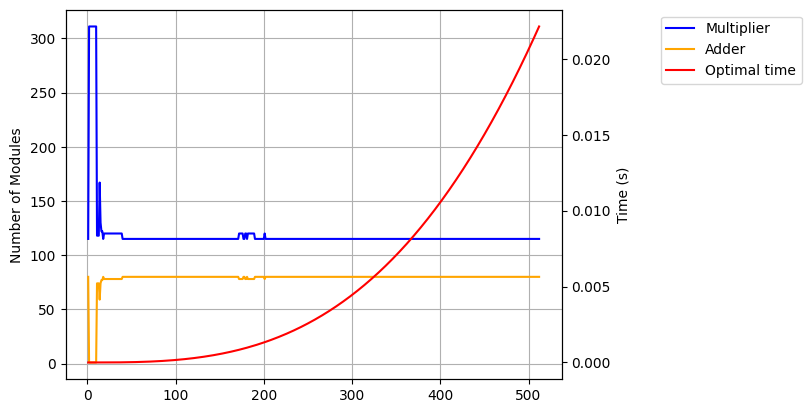

In [12]:
inputMatricesSolve = []

for i in range(1, 513) :
  inputMatrix = i

  multiplierTimeExpr = (cp.power(inputMatrix, 3) * cp.inv_pos(multiplier)) * multiplierTimeDelay
  adderTimeExpr = (((cp.power(inputMatrix, 2) * (inputMatrix - 1)) * cp.inv_pos(adder))) * adderTimeDelay

  objective = cp.Minimize(multiplierTimeExpr + adderTimeExpr)

  problem = cp.Problem(objective, constraints)
  problem.solve(solver=cp.GUROBI)

  inputMatricesSolve.append([i, problem.value, multiplier.value, adder.value])

xpoints = [i[0] for i in inputMatricesSolve]
multiplierPlot = [i[2] for i in inputMatricesSolve]
adderPlot = [i[3] for i in inputMatricesSolve]
optimalValue = [i[1] for i in inputMatricesSolve]

fig, ax1 = plt.subplots()

ax1.plot(xpoints, multiplierPlot, label = "Multiplier", color = "blue")
ax1.plot(xpoints, adderPlot, label = "Adder", color = "orange")
ax1.grid()

ax1.set_ylabel("Number of Modules")

ax2 = ax1.twinx()
ax2.plot(xpoints, optimalValue, label = "Optimal time", color = "red")

ax2.set_ylabel("Time (s)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=(1.2, 0.8))

# Define the constraints
A = [
    lambda adder, multiplier: FFPerMultiplier * multiplier + FFPerAdder * adder,
    lambda adder, multiplier: LUTPerMultiplier * multiplier + LUTPerAdder * adder
]

rhs = [
    FFMax,
    LUTMax
]

Global minimum: (80, 115, 0.0221)


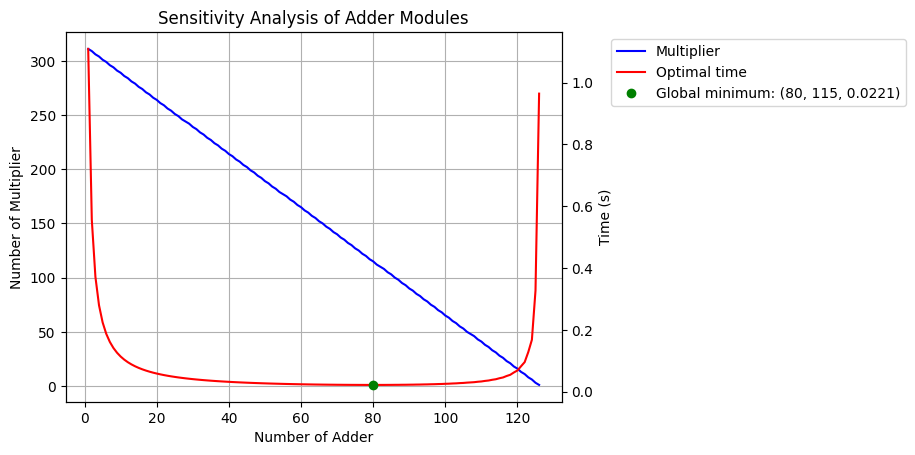

In [13]:
adderVariation = []

for i in range(1, 127):
  # Define the constraints
  constraints = [
    multiplier >= 1,
    adder == i,
    maxLUTConstraint <= LUTMax,
    maxFFConstraint <= FFMax,
    multiplier <= (cp.power(inputMatrix,3)),
    adder <= (cp.power(inputMatrix, 2)*(inputMatrix - 1))
  ]

  objective = cp.Minimize(multiplierTimeExpr + adderTimeExpr)
  problem = cp.Problem(objective, constraints)
  problem.solve(solver=cp.GUROBI)

  adderVariation.append([adder.value, problem.value, multiplier.value])

optimalValues = [i[1] for i in adderVariation]

minimumTime = adderVariation[optimalValues.index(min(optimalValues))]

fig, ax1 = plt.subplots()

l1 = ax1.plot([i[0] for i in adderVariation], [i[2] for i in adderVariation], label = "Multiplier", color = "blue")
ax1.set_ylabel("Number of Multiplier")

ax2 = ax1.twinx()
l2 = ax2.plot([i[0] for i in adderVariation], [i[1] for i in adderVariation], label = "Optimal time", color = "red")
minimumDotLabel = f"Global minimum: ({int(minimumTime[0])}, {int(minimumTime[2])}, {minimumTime[1]:.4f})"
print(minimumDotLabel)
ax2.plot(minimumTime[0], minimumTime[1], 'go', label = minimumDotLabel)
ax2.set_ylabel("Time (s)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=(1.1, 0.8))

ax1.set_xlabel("Number of Adder")
ax1.grid()
plt.title("Sensitivity Analysis of Adder Modules")
plt.show()

In [ ]:
multiplierVariation = []

for i in range(1, 312):
  # Define the constraints
  constraints = [
    adder >= 1,
    multiplier == i,
    maxLUTConstraint <= LUTMax,
    maxFFConstraint <= FFMax,
    multiplier <= (cp.power(inputMatrix,3)),
    adder <= (cp.power(inputMatrix, 2)*(inputMatrix - 1))
  ]

  objective = cp.Minimize(multiplierTimeExpr + adderTimeExpr)
  problem = cp.Problem(objective, constraints)
  problem.solve(solver=cp.GUROBI)

  multiplierVariation.append([multiplier.value, problem.value, adder.value])

optimalValues = [i[1] for i in multiplierVariation]

minimumTime = multiplierVariation[optimalValues.index(min(optimalValues))]

fig, ax1 = plt.subplots()

ax1.plot([i[0] for i in multiplierVariation], [i[2] for i in multiplierVariation], label = "Adder", color = "blue")
ax1.set_ylabel("Number of Adder")

ax2 = ax1.twinx()
ax2.plot([i[0] for i in multiplierVariation], [i[1] for i in multiplierVariation], label = "Optimal time", color = "red")
minimumDotLabel = f"Global minimum: ({int(minimumTime[0])}, {int(minimumTime[2])}, {minimumTime[1]:.4f})"
print(minimumDotLabel)
ax2.plot(minimumTime[0], minimumTime[1], 'go', label = minimumDotLabel)
ax2.set_ylabel("Time (s)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=(1.1, 0.8))

ax1.set_xlabel("Number of Multiplier")
plt.title("Sensitivity Analysis of Multiplier Modules")
ax1.grid()
plt.show()

Global minimum: (115, 80, 0.0221)
